# Train NaiveBayes + SVM arxiv categories classifier on arxiv abstracts

This notebook is based on Jeremy's notebook https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline .

In [1]:
%cd ~/paperswithcode/paper-extractor

/home/ubuntu/paperswithcode/paper-extractor


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import pickle

DATA_PATH = Path("notebooks/shared-notebooks/arxiv-class")
TRAIN_PATH = DATA_PATH / "arxiv-tag-classifier-data.json"
TEST_PATH = DATA_PATH / "classifier.tsv"

In [3]:
train_df = pd.read_pickle(DATA_PATH / "train_df.pkl.gz")
valid_df = pd.read_pickle(DATA_PATH / "valid_df.pkl.gz")
test_df = pd.read_pickle(DATA_PATH / "test_df.pkl.gz")

In [4]:
classes = sorted(set((' '.join(train_df.categories.values)).split()))

In [5]:
lens = train_df.abstract.str.len()
lens.mean(), lens.std(), lens.max()

(881.2940220556924, 421.13034222846056, 6091)

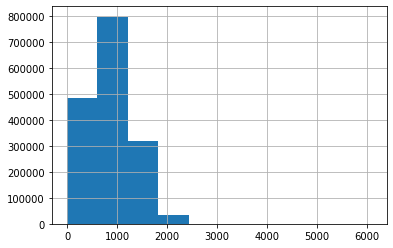

In [6]:
%matplotlib inline
lens.hist()

In [7]:
len(classes)

176

In [8]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [9]:
train_df["text"] = train_df["title"] + " " + train_df["abstract"]
valid_df["text"] = valid_df["title"] + " " + valid_df["abstract"]
test_df["text"] = test_df["title"] + " " + test_df["abstract"]

In [122]:
train_df15 = train_df[train_df.date.dt.year > 2014]
classes15 = sorted(set((' '.join(train_df15.categories.values)).split()))
c2i15 = {c:i for i, c in enumerate(classes15)}
train_labels15 = np.zeros((len(train_df15), len(classes15)), dtype=np.uint8)
for i, (_, row) in enumerate(train_df15.iterrows()):
    for cat in row.categories.split():
        train_labels15[i, c2i15[cat]] = 1

In [123]:
cnt15 = Counter(dict(zip(classes15, train_labels15.sum(axis=0))))

In [124]:
len(classes15)

156

In [128]:
np.array([x[0] for x in cnt15.most_common(155)])

array(['cs.LG', 'quant-ph', 'hep-ph', 'hep-th', 'cs.CV', 'stat.ML',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'gr-qc', 'astro-ph.GA',
       'math.CO', 'math.AP', 'astro-ph.SR', 'math-ph', 'math.MP',
       'astro-ph.HE', 'astro-ph.CO', 'cond-mat.str-el', 'math.PR',
       'cs.IT', 'math.IT', 'math.OC', 'cond-mat.stat-mech', 'cs.AI',
       'physics.optics', 'cs.CL', 'math.AG', 'hep-ex', 'math.NA',
       'math.NT', 'nucl-th', 'math.DG', 'math.DS', 'cond-mat.soft',
       'astro-ph.EP', 'astro-ph.IM', 'math.FA', 'cs.CR',
       'cond-mat.supr-con', 'stat.ME', 'cs.DS', 'physics.flu-dyn',
       'cs.SY', 'physics.ins-det', 'math.RT', 'cond-mat.quant-gas',
       'cs.RO', 'cs.SI', 'math.CA', 'cs.NI', 'physics.comp-ph', 'cs.DC',
       'math.ST', 'stat.TH', 'eess.SP', 'nucl-ex', 'physics.chem-ph',
       'physics.soc-ph', 'physics.app-ph', 'math.GR', 'physics.atom-ph',
       'stat.AP', 'math.GT', 'cs.NE', 'cs.LO', 'cs.CY', 'hep-lat',
       'math.RA', 'physics.plasm-ph', 'math.CV',

In [10]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
# n = train_df.shape[0]
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1,
#                max_features=1000000)

# trn_term_doc = vec.fit_transform(train_df["text"])

# with Path(DATA_PATH / "models/tfidf_vec_1m.pkl").open("wb") as f:
#     pickle.dump(vec, f)

In [ ]:
# n = train_df.shape[0]
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1)

# trn_term_doc = vec.fit_transform(train_df["text"])

# with Path(DATA_PATH / "models/tfidf_vec_all.pkl").open("wb") as f:
#     pickle.dump(vec, f)

In [11]:
with Path(DATA_PATH / "models/tfidf_vec_1m.pkl").open("rb") as f:
    vec = pickle.load(f)

trn_term_doc = vec.transform(train_df["text"])

In [12]:
test_term_doc = vec.transform(test_df["text"])

In [13]:
with Path(DATA_PATH / "models/trn_term_doc_tfidf_vec_1m.pkl").open("wb") as f:
    pickle.dump(trn_term_doc, f)

with Path(DATA_PATH / "models/test_term_doc_tfidf_vec_1m.pkl").open("wb") as f:
    pickle.dump(test_term_doc, f)

In [15]:
len(vec.vocabulary_)

1000000

In [16]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [18]:
x = trn_term_doc
test_x = test_term_doc

In [19]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [37]:
from joblib import Parallel, delayed

In [40]:
c2i = {c:i for i, c in enumerate(classes)}

In [42]:
train_labels = np.zeros((len(train_df), len(classes)), dtype=np.uint8)
for i, (_, row) in enumerate(train_df.iterrows()):
    for cat in row.categories.split():
        train_labels[i, c2i[cat]] = 1

In [43]:
with Path(DATA_PATH / f"train_labels.pkl").open("wb") as f:
    pickle.dump(train_labels, f)


In [73]:
target = np.minimum(train_labels.sum(axis=0), 2000).astype(np.int)

In [53]:
shuf = list(range(len(train_df)))
np.random.shuffle(shuf)

In [74]:
indices = []
idx = 0
while (target > 0).any():
    labels = train_labels[shuf[idx]]
    if (target[labels != 0] > 0).any():
        indices.append(shuf[idx])
        target -= labels
    idx += 1

In [75]:
len(indices)

229436

In [76]:
indices = sorted(indices)

In [85]:
x = trn_term_doc[indices]
y_df = train_df.iloc[indices]
test_x = test_term_doc

In [88]:
preds = np.zeros((len(test_df), len(classes)))

def get_labels(df, cls):
    return df.categories.str.contains(r"\b"+re.escape(cls)+r"\b")


def train_for(cls):
    j = cls
    print('starting fit', j)
    m,r = get_mdl(get_labels(y_df, j))

    with Path(DATA_PATH / "models/nbsvm" / f"model_{j}.pkl").open("wb") as f:
        pickle.dump((m, r), f)
    print('finished fit', j)

Parallel(backend="multiprocessing", n_jobs=8)(delayed(train_for)(cls) for cls in classes)
#for i, j in enumerate(classes[0:1]):
#     preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

starting fit acc-phys
starting fit adap-org
starting fit alg-geom
starting fit ao-sci
starting fit astro-ph
starting fit astro-ph.CO
starting fit astro-ph.EP
starting fit astro-ph.GA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

finished fit ao-sci
starting fit astro-ph.HE


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit alg-geom
starting fit astro-ph.IM
finished fit astro-ph.EP
starting fit astro-ph.SR
finished fit astro-ph.GA
starting fit atom-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit acc-phys
starting fit bayes-an


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit astro-ph
starting fit chao-dyn


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit astro-ph.CO
starting fit chem-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit bayes-an
starting fit cmp-lg


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit astro-ph.HE
starting fit comp-gas


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit astro-ph.SR
starting fit cond-mat


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit atom-ph
starting fit cond-mat.dis-nn


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cmp-lg
starting fit cond-mat.mes-hall
finished fit chem-ph
starting fit cond-mat.mtrl-sci


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit astro-ph.IM
starting fit cond-mat.other


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat
starting fit cond-mat.quant-gas


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


finished fit adap-org
starting fit cond-mat.soft


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit comp-gas
starting fit cond-mat.stat-mech


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.other
starting fit cond-mat.str-el


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit chao-dyn
starting fit cond-mat.supr-con
finished fit cond-mat.dis-nn
starting fit cs.AI


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.mes-hall
starting fit cs.AR
finished fit cond-mat.mtrl-sci
starting fit cs.CC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.quant-gas
starting fit cs.CE


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.stat-mech
starting fit cs.CG
finished fit cond-mat.soft
starting fit cs.CL


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.str-el
starting fit cs.CR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.AR
starting fit cs.CV


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cond-mat.supr-con
starting fit cs.CY


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.AI
starting fit cs.DB
finished fit cs.CG
starting fit cs.DC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.CR
starting fit cs.DL


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.CL
starting fit cs.DM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.CC
starting fit cs.DS
finished fit cs.CE
starting fit cs.ET


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.CV
starting fit cs.FL


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.CY
starting fit cs.GL


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.DC
starting fit cs.GR
finished fit cs.DB
starting fit cs.GT
finished fit cs.DL
starting fit cs.HC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.DS
starting fit cs.IR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.ET
starting fit cs.IT
finished fit cs.FL
starting fit cs.LG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.GL
starting fit cs.LO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.DM
starting fit cs.MA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.IT
starting fit cs.MM
finished fit cs.IR
starting fit cs.MS
finished fit cs.HC
starting fit cs.NA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.GR
starting fit cs.NE


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.LG
starting fit cs.NI


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.GT
starting fit cs.OH


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.MM
starting fit cs.OS
finished fit cs.MA
starting fit cs.PF
finished fit cs.LO
starting fit cs.PL
finished fit cs.NI
starting fit cs.RO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.MS
starting fit cs.SC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.NE
starting fit cs.SD


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.OH
starting fit cs.SE


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.NA
starting fit cs.SI


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.PF
starting fit cs.SY


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.SC
starting fit dg-ga


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.RO
starting fit econ.EM
finished fit cs.OS
starting fit econ.GN


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.PL
starting fit econ.TH
finished fit cs.SD
starting fit eess.AS


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.SE
starting fit eess.IV


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit dg-ga
starting fit eess.SP


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit cs.SY
starting fit eess.SY
finished fit cs.SI
starting fit funct-an


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit econ.EM
starting fit gr-qc
finished fit econ.GN
starting fit hep-ex


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit eess.AS
starting fit hep-lat


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit econ.TH
starting fit hep-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit eess.IV
starting fit hep-th


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit eess.SY
starting fit math-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit hep-lat
starting fit math.AC
finished fit funct-an
starting fit math.AG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit hep-ph
starting fit math.AP
finished fit eess.SP
starting fit math.AT
finished fit hep-th
starting fit math.CA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit hep-ex
starting fit math.CO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit gr-qc
starting fit math.CT


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math-ph
starting fit math.CV
finished fit math.AG
starting fit math.DG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.AT
starting fit math.DS


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.AC
starting fit math.FA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.CA
starting fit math.GM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.AP
starting fit math.GN


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.CV
starting fit math.GR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.CO
starting fit math.GT
finished fit math.DG
starting fit math.HO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.CT
starting fit math.IT


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.DS
starting fit math.KT


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.FA
starting fit math.LO
finished fit math.GM
starting fit math.MG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.GR
starting fit math.MP


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.HO
starting fit math.NA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.GN
starting fit math.NT
finished fit math.IT
starting fit math.OA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.GT
starting fit math.OC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.KT
starting fit math.PR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.LO
starting fit math.QA


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.MP
starting fit math.RA
finished fit math.NA
starting fit math.RT


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.MG
starting fit math.SG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.OA
starting fit math.SP


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.NT
starting fit math.ST
finished fit math.PR
starting fit mtrl-th


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.QA
starting fit nlin.AO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.OC
starting fit nlin.CD


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.RA
starting fit nlin.CG


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.RT
starting fit nlin.PS


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.SG
starting fit nlin.SI


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit mtrl-th
starting fit nucl-ex
finished fit math.SP
starting fit nucl-th


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit math.ST
starting fit patt-sol


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit nlin.CG
starting fit physics.acc-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit nlin.AO
starting fit physics.ao-ph
finished fit nlin.SI
starting fit physics.app-ph
finished fit nlin.CD
starting fit physics.atm-clus


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit nucl-ex
starting fit physics.atom-ph
finished fit nucl-th
starting fit physics.bio-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit nlin.PS
starting fit physics.chem-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.acc-ph
starting fit physics.class-ph
finished fit physics.atm-clus
starting fit physics.comp-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.app-ph
starting fit physics.data-an
finished fit physics.atom-ph
starting fit physics.ed-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.comp-ph
starting fit physics.flu-dyn
finished fit patt-sol
starting fit physics.gen-ph
finished fit physics.class-ph
starting fit physics.geo-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.data-an
starting fit physics.hist-ph
finished fit physics.ed-ph
starting fit physics.ins-det


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.bio-ph
starting fit physics.med-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


finished fit physics.ao-ph
starting fit physics.optics


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.chem-ph
starting fit physics.plasm-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.flu-dyn
starting fit physics.pop-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.gen-ph
starting fit physics.soc-ph
finished fit physics.hist-ph
starting fit physics.space-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.geo-ph
starting fit plasm-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.ins-det
starting fit q-alg
finished fit physics.med-ph
starting fit q-bio


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.plasm-ph
starting fit q-bio.BM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.optics
starting fit q-bio.CB
finished fit physics.pop-ph
starting fit q-bio.GN


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit plasm-ph
starting fit q-bio.MN
finished fit q-alg
starting fit q-bio.NC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit physics.soc-ph
starting fit q-bio.OT
finished fit physics.space-ph
starting fit q-bio.PE


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio
starting fit q-bio.QM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.BM
starting fit q-bio.SC


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.CB
starting fit q-bio.TO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.OT
starting fit q-fin.CP


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.PE
starting fit q-fin.EC
finished fit q-bio.GN
starting fit q-fin.GN


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.SC
starting fit q-fin.MF
finished fit q-bio.NC
starting fit q-fin.PM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.QM
starting fit q-fin.PR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.TO
starting fit q-fin.RM


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-bio.MN
starting fit q-fin.ST


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.EC
starting fit q-fin.TR


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.PM
starting fit quant-ph


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.GN
starting fit solv-int


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.CP
starting fit stat.AP
finished fit q-fin.PR
starting fit stat.CO


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.ST
starting fit stat.ME


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.RM
starting fit stat.ML
finished fit q-fin.MF
starting fit stat.OT


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit quant-ph
starting fit stat.TH


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit solv-int
starting fit supr-con


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit q-fin.TR
finished fit stat.ML
finished fit stat.CO
finished fit stat.AP
finished fit stat.TH
finished fit stat.OT
finished fit supr-con


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


finished fit stat.ME


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [101]:
def dump_test_preds(preds, classes, name, desc, info=None):
    with (DATA_PATH / "preds" / "test" / f"{name}.pkl").open("wb") as f:
        pickle.dump((preds, classes, name, desc, info), f)

def load_test_preds(name):
    with (DATA_PATH / "preds" / "test" / f"{name}.pkl").open("rb") as f:
        preds, classes, name, desc, info = pickle.load(f)
    return preds, classes, name, desc, info

In [102]:
test_df = pd.read_pickle(DATA_PATH / "test_df.pkl.gz")
test = pd.read_csv(TEST_PATH, sep="\t", header=None, names=["arxiv_id", "tags", "output"])

# keep only test papers for which we have abstracts

import re
aidv_re = re.compile("(v\d+)?$")
test["no_version"] = test.arxiv_id.str.replace(aidv_re, "")
test = test.drop_duplicates(["no_version"])

test_df = test_df[test_df.arxiv_id.isin(test.no_version)]
test_df = test_df.drop_duplicates(["arxiv_id"])

test = test[test.no_version.isin(test_df.arxiv_id)]

test = test.sort_values("no_version")
test_df = test_df.sort_values("arxiv_id")

In [105]:
test_df["text"] = test_df["title"] + " " + test_df["abstract"]

In [106]:
test_term_doc = vec.transform(test_df["text"])
test_x = test_term_doc

In [107]:
preds = np.zeros((len(test_df), len(classes)))

for i, cls in enumerate(classes):
    with Path(DATA_PATH / "models/nbsvm" / f"model_{cls}.pkl").open("rb") as f:
        m, r = pickle.load(f)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

In [108]:
dump_test_preds(preds, classes, "nbsvm",
                """predictions from 176 1-vs-others NBSVM models trained on
                train_df subset (see info['indices']) ensuring that each class
                appears ~2000 times (or smaller for rare classes)
                """,
                info={'indices': indices})

In [115]:
from collections import Counter
cnt = Counter(dict(zip(classes, train_labels.sum(axis=0))))

In [116]:
[x for x in cnt if 'supr' in x]

['cond-mat.supr-con', 'supr-con']

In [118]:
[x for x in cnt if len([y for y in cnt if y != x and x.lower() in y.lower()])]

['astro-ph',
 'atom-ph',
 'chem-ph',
 'cond-mat',
 'cs.CL',
 'cs.FL',
 'cs.PL',
 'plasm-ph',
 'q-bio',
 'supr-con']

In [117]:
cnt.most_common()

[('hep-ph', 147875),
 ('hep-th', 135111),
 ('astro-ph', 105183),
 ('quant-ph', 92680),
 ('gr-qc', 80362),
 ('cond-mat.mes-hall', 66429),
 ('cond-mat.mtrl-sci', 62243),
 ('math-ph', 60109),
 ('math.MP', 60109),
 ('cond-mat.stat-mech', 57316),
 ('cond-mat.str-el', 55589),
 ('astro-ph.CO', 49962),
 ('cs.LG', 48675),
 ('nucl-th', 44020),
 ('math.CO', 43565),
 ('astro-ph.SR', 41522),
 ('hep-ex', 40731),
 ('astro-ph.GA', 39996),
 ('math.AP', 39430),
 ('math.AG', 39095),
 ('math.PR', 38450),
 ('astro-ph.HE', 36882),
 ('cs.CV', 36299),
 ('stat.ML', 35425),
 ('cond-mat.supr-con', 34851),
 ('math.DG', 31253),
 ('cs.IT', 30624),
 ('math.IT', 30624),
 ('cond-mat.soft', 29158),
 ('math.NT', 28289),
 ('physics.optics', 27770),
 ('math.OC', 24333),
 ('math.DS', 24099),
 ('hep-lat', 23140),
 ('cs.AI', 22278),
 ('math.FA', 21255),
 ('math.NA', 19986),
 ('nucl-ex', 19243),
 ('math.RT', 18788),
 ('cond-mat.dis-nn', 18017),
 ('astro-ph.EP', 17719),
 ('cs.CL', 17214),
 ('astro-ph.IM', 17092),
 ('math.GT', 

In [87]:
train_for(classes[0])

starting fit acc-phys


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


finished fit acc-phys


In [26]:
tp = m.predict_proba(x.multiply(r))[:,1]

In [32]:
classes[1]

'adap-org'

In [33]:
((tp > 0.5) == get_labels(train_df, 'adap-org')).mean()

0.9996157630163337

In [35]:
get_labels(test_df, j).value_counts()

False    10315
Name: categories, dtype: int64

In [36]:
with Path(DATA_PATH / "models/nbsvm" / f"model_{j}.pkl").open("wb") as f:
    pickle.dump((m, r), f)

In [34]:
preds[:,0].max()

0.00012932901519105707

In [ ]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
import re
aidv_re = re.compile("(v\d+)?$")
test_no_version = test.arxiv_id.str.replace(aidv_re, "")

In [7]:
all_df = pd.DataFrame(train)

In [8]:
all_df.date = pd.to_datetime(all_df.date, infer_datetime_format=True)

In [9]:
filtered = all_df[~all_df.arxiv_id.isin(test_no_version)]

In [10]:
train_df = filtered[filtered.date.dt.year<2020]
valid_df = filtered[~(filtered.date.dt.year<2020)]

In [11]:
text_cols = ["title", "abstract"]
valid_tl = TextList.from_df(valid_df, MODELS_PATH, cols=text_cols, processor=processor)

In [12]:
train_tl = TextList.from_df(train_df, MODELS_PATH, cols=text_cols, processor=processor)

In [13]:
data_clas = ItemLists(MODELS_PATH, train_tl, valid_tl)\
    .label_from_df(["categories"], label_delim=" ")\
    .databunch(bs=64)

In [14]:
data_clas.save("data_clas_abs.pkl")

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
test_df = all_df[all_df.arxiv_id.isin(test_no_version)]

In [16]:
train_df.to_pickle(DATA_PATH / "train_df.pkl.gz")
valid_df.to_pickle(DATA_PATH / "valid_df.pkl.gz")
test_df.to_pickle(DATA_PATH / "test_df.pkl.gz")

In [176]:
def set_seed(seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)

In [177]:
spulmfit_path=Path("/home/ubuntu/paperswithcode/paper-extractor/models/ulmfit_baseline")

set_seed(42)
learn = text_classifier_learner(data_clas, AWD_LSTM)

In [178]:
learn.load_encoder(spulmfit_path / "models"/ "pretrained-on-papers_enc.pkl")

In [179]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.033447,0.028418,36:16


In [180]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,time
0,0.025298,0.024094,51:55


In [181]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,time
0,0.021932,0.022140,1:33:16
1,0.019765,0.020655,1:44:28
2,0.018430,0.020145,1:49:05
3,0.018067,0.019065,1:38:02
4,0.017113,0.018982,1:37:19
5,0.018216,0.018868,1:48:41


In [182]:
learn.save("arxiv_class_sp30k_1_1_6_abstracts.pkl")